# <center>Predict Harvest Quantity

In [23]:
# helper functions
%run -i imports.py
%run -i modelling_functions.py

# load class
from harvestingtime import district

# load dataset
with open('data/dataset.pkl', 'rb') as file:
    ds = pickle.load(file)

In [32]:
# set parameters
crop = 'Silomais'    # crop
dc = '03151'         # district code
iterations = 5      # number of iterations for model

## create crop specific dataset

In [25]:
# calling to_crop() method to get weather and climate data for 
# crop specific growing period

cols = ['district', 'year', 'crop', 'TT', 'SD', 'FK', 'RR', 'SMI_OB', 'SMI_GB']
crop_df = pd.DataFrame(columns=cols)

for dc in ds.keys():
    x = pd.DataFrame(columns=cols)

    for i in cols[3:]:
        x.loc[:, i] = ds[dc].to_crop(crop)[i].mean(axis=1)

    x['district'] = dc
    x['year'] = ds[dc].crops.index
    x['crop'] = ds[dc].crops.loc[:, crop].tolist()
    
    crop_df = pd.concat((crop_df, x))

crop_df.dropna(axis=0, inplace=True)

In [26]:
print(crop_df.shape)
crop_df.head()

(6097, 9)


,district,year,crop,TT,SD,FK,RR,SMI_OB,SMI_GB
0,01001,1999,401.6,15.053036,229.337500,2.618571,67.832143,0.467129,0.591105
1,01001,2000,342.8,14.531845,200.933333,2.584917,52.479167,0.322052,0.425855
2,01001,2001,401.6,15.072738,225.700000,2.420714,72.616071,0.562898,0.529012
3,01001,2002,364.2,16.376786,201.983333,2.659821,108.433929,0.793085,0.875195
4,01001,2003,408.4,16.379702,236.416667,2.506333,71.591071,0.550395,0.555351


## prepare data for model

In [6]:
polyfeat = PolynomialFeatures(degree=2)
scaler   = StandardScaler()
onehot   = OneHotEncoder(sparse=False)

X, y = crop_df[['TT', 'SD', 'RR', 'SMI_OB', 'SMI_GB']].copy(), crop_df['crop'].copy() # omitting wind ('FK')

# polynomial features
X_poly_ = polyfeat.fit(X)
X_poly  = X_poly_.transform(X)

# feature scaling
X_scal_ = scaler.fit(X_poly)
X_scal  = X_scal_.transform(X_poly)

# one hot encoding districts
dcode = crop_df['district'].to_numpy().reshape(-1, 1)
ohe_ = onehot.fit(dcode)
ohe  = onehot.transform(dcode)

# scaled dataset with oh-encoded 
X_full = np.concatenate((X_scal, ohe), axis=1)

# boxcox transformation of target
y_bxcx, bxcxlmbd = boxcox(y)

In [7]:
# check columns of polynomial features of precipitation
polyfeat_labels_ = X_poly_.get_feature_names_out().tolist()

polyfeat_labels = []
for i, label in enumerate(polyfeat_labels_):
    polyfeat_labels.append([i, label])

print(polyfeat_labels)

[[0, '1'], [1, 'TT'], [2, 'SD'], [3, 'RR'], [4, 'SMI_OB'], [5, 'SMI_GB'], [6, 'TT^2'], [7, 'TT SD'], [8, 'TT RR'], [9, 'TT SMI_OB'], [10, 'TT SMI_GB'], [11, 'SD^2'], [12, 'SD RR'], [13, 'SD SMI_OB'], [14, 'SD SMI_GB'], [15, 'RR^2'], [16, 'RR SMI_OB'], [17, 'RR SMI_GB'], [18, 'SMI_OB^2'], [19, 'SMI_OB SMI_GB'], [20, 'SMI_GB^2']]


In [8]:
# get means and standard deviations for all features with precipitation
# needed for manipulation later
x2_mn, x2_sd     = np.mean(X_poly[:,  3]), np.std(X_poly[:,  3])
x22_mn, x22_sd   = np.mean(X_poly[:, 15]), np.std(X_poly[:, 15])
x0x2_mn, x0x2_sd = np.mean(X_poly[:,  8]), np.std(X_poly[:,  8])
x1x2_mn, x1x2_sd = np.mean(X_poly[:, 12]), np.std(X_poly[:, 12])
x2x3_mn, x2x3_sd = np.mean(X_poly[:, 16]), np.std(X_poly[:, 16])
x2x4_mn, x2x4_sd = np.mean(X_poly[:, 17]), np.std(X_poly[:, 17])

## modelling the increase of harvest quantity depending on precipitation

In [37]:
# maximum of precipitation
max_precip = 600

min_val_it = np.zeros((max_precip, iterations))
max_val_it = np.zeros((max_precip, iterations))
mean_val_it = np.zeros((max_precip, iterations))

for iteration in np.arange(0, iterations):
    print(f'iteration: {iteration+1}/{iterations}', end='\r')
    
    #bagging model
    bagg_reg = BaggingRegressor(n_estimators=100, n_jobs=-1).fit(X_full, y_bxcx)
    y_bagg = bagg_reg.predict(X_full)

    #inverse boxcox
    y_pred = inv_boxcox(y_bagg, bxcxlmbd)

    #difference between true and predicted values
    y_diff = [a-b for a,b in zip(y, y_pred)]

    #function of difference of predicted versus true values
    pf_coef = poly.polyfit(y_pred, y_diff, deg=2)

    #computing corrected predicted values
    y_corr = [(pf_coef[0]+pf_coef[1]*x+pf_coef[2]*x**2) for x in y_pred]
    y_corr = y_corr+y_pred

    idx_dstrct = crop_df[crop_df['district']==dc].index.tolist()

    X_dstrct = X_full[idx_dstrct]

    #district position in ohe
    dc_pos = np.where(ohe_.get_feature_names_out()==str('x0_'+ dc))[0][0]
    dc_len = len(ohe_.get_feature_names_out())

    district_poly = X_poly[idx_dstrct]
    district_scal = X_scal[idx_dstrct]

    district_fict = []

    #create empty ndarray
    oh = np.zeros(dc_len)

    #1 for one hot encoded district
    oh[dc_pos] = 1

    for year in np.arange(0, len(district_poly)):
        #empty array
        fict_data = np.ndarray((max_precip, (dc_len+21)))

        #create fictional data set
        for newrr in np.arange(0, max_precip):
            fict = compute_fict(district_poly[year], district_scal[year], newrr)
            fict = np.append(fict, oh)

            fict_data[newrr] = fict

        district_fict = district_fict + [fict_data]

    n_years = len(district_fict)

    dx_    = crop_df[['year', 'RR', 'crop']][crop_df['district']==dc]
    values = np.zeros((max_precip, n_years))

    for j in np.arange(0, n_years):
        #predicting values
        t = bagg_reg.predict(district_fict[j])
        #inverted boxcox of predicted values
        t = [inv_boxcox(x, bxcxlmbd) for x in t]
        #correct the values using relationship of real versus predicted values of general model
        t_corr = [(pf_coef[0]+pf_coef[1]*x+pf_coef[2]*x**2) for x in t]
        t_corr = [t_corr + t for t_corr,t in zip(t_corr, t)]
        #write values per year to array
        values[:,j] = t_corr

    min_val  = [np.percentile(values[x,:], q=10) for x in np.arange(0, values.shape[0])]
    max_val  = [np.percentile(values[x,:], q=90) for x in np.arange(0, values.shape[0])]
    mean_val = [np.percentile(values[x,:], q=50) for x in np.arange(0, values.shape[0])]

    min_val_it[:, iteration] = min_val
    max_val_it[:, iteration] = max_val
    mean_val_it[:, iteration] = mean_val

min_val_ = [np.mean(min_val_it[x]) for x in np.arange(0, max_precip)]
max_val_ = [np.mean(max_val_it[x]) for x in np.arange(0, max_precip)]
mean_val_ = [np.mean(mean_val_it[x]) for x in np.arange(0, max_precip)]

## plot results

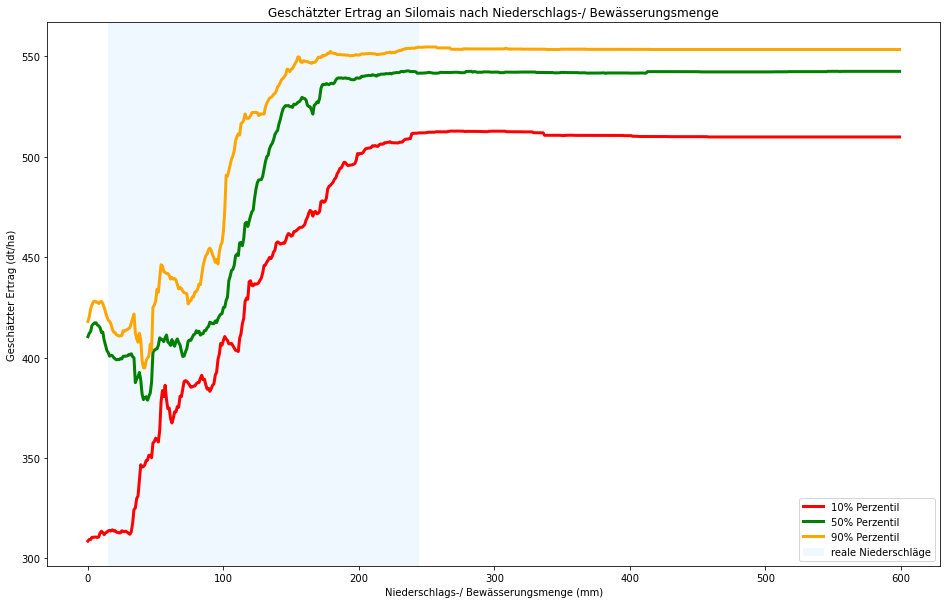

In [42]:
fig, ax = plt.subplots(figsize=(16,10))

ax.axvspan(crop_df['RR'].min(), crop_df['RR'].max(), color='aliceblue', zorder=0, label='reale Niederschläge')
ax.set_xlabel('Niederschlags-/ Bewässerungsmenge (mm)')
ax.set_ylabel('Geschätzter Ertrag (dt/ha)')
#ax.set_title(str('Geschätzter Ertrag an ' + crop + ' nach Niederschlagsmenge für den Landkreis ' + dc))
ax.set_title(str('Geschätzter Ertrag an ' + crop + ' nach Niederschlags-/ Bewässerungsmenge'))
sns.lineplot(x=np.arange(0, max_precip), y=min_val_, color='red', linewidth=3, ax=ax, label='10% Perzentil')
sns.lineplot(x=np.arange(0, max_precip), y=mean_val_, color='green', linewidth=3, ax=ax, label='50% Perzentil')
sns.lineplot(x=np.arange(0, max_precip), y=max_val_, color='orange', linewidth=3, ax=ax, label='90% Perzentil')
#sns.scatterplot(x=dx_['RR'], y=dx_['Ertrag'], ax=ax, label='reale Erträge')

y0, y1 = ax.get_ylim()

#ax.vlines(x=dx_['RR'].mean(), ymin=(y0*1.05), ymax=(y1*0.95), linewidth=1, label='durchschnittlicher Niederschlag')
#ax.vlines(x=dx_['RR'].mean()+irrigation, ymin=(y0*1.05), ymax=(y1*0.95), linewidth=1, linestyle='--', 
#          label='durchschnittlicher Bewässerungsbedarf\nnach Cropwat')

#plt.savefig(str('results/' + crop + ' in ' + dc + '.jpg'), dpi=300)
#plt.savefig(str('results/' + crop + ' Beispiel.jpg'), dpi=600, bbox_inches='tight')
plt.show()